
# Hackathon - Binary Classification - Solutions

In this notebook you will find the instructor's solution to the hackathon. This is one approach of many possible.
The main goal is to provide you a baseline that you can modify/expand upon and show you how to take advantage of sklearn's pipeline to simplify your workflow.

### Import the necessary libraries

In [2]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc
from sklearn.base import BaseEstimator, TransformerMixin # to create classes
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

# Category encoders
from category_encoders import OneHotEncoder, TargetEncoder

#### Import the dataset

In [3]:
# You might have to change this path or the location of this file
data = pd.read_csv('data/train.csv').set_index("id")

In [4]:
data.head()

,user_address,user_balance_usd,user_balance_coin_a,user_historical_transactions_10s,user_historical_transactions_30s,exchange_a_price,exchange_b_price,exchange_a_volatility,exchange_b_volatility,anonymous,result
id,,,,,,,,,,,
8,0x930B,84139.092267,44.193560,0,0,66.742521,66.8325,very high,0.000367,A113,0
12,0x5779,34609.449276,331.501171,0,0,41.429574,41.5401,low,0.000695,M958,0
28,0x5779,30598.783296,1581.902691,0,0,35.817631,35.8701,very low,0.000431,F255,0
50,0x5779,20992.680359,1260.406181,0,0,47.711827,47.8233,low,0.000456,F2332,0
56,0xD47A,120838.946555,180.090128,0,0,52.812842,52.6869,low,NaN,A198,0


### EDA (Exploratory Dataset Analysis)

Let's start by checking the data types we are dealing with.

In [5]:
data.dtypes

user_address                         object
user_balance_usd                    float64
user_balance_coin_a                 float64
user_historical_transactions_10s      int64
user_historical_transactions_30s      int64
exchange_a_price                    float64
exchange_b_price                    float64
exchange_a_volatility                object
exchange_b_volatility               float64
anonymous                            object
result                                int64
dtype: object

Let's check the number of unique values in our dataset.

In [6]:
data.nunique()

user_address                             8
user_balance_usd                    338487
user_balance_coin_a                 338487
user_historical_transactions_10s         4
user_historical_transactions_30s         7
exchange_a_price                     55178
exchange_b_price                     32414
exchange_a_volatility                    5
exchange_b_volatility               329314
anonymous                             4080
result                                   2
dtype: int64

Let's check if we have any missing values to worry about.

In [7]:
data.isna().sum()

user_address                            0
user_balance_usd                        0
user_balance_coin_a                     0
user_historical_transactions_10s        0
user_historical_transactions_30s        0
exchange_a_price                    28642
exchange_b_price                        0
exchange_a_volatility               15210
exchange_b_volatility                7922
anonymous                               0
result                                  0
dtype: int64

There are a lot of missing values here. We will have to find a way to deal with them...

What about correlation?

In [8]:
data.corr()[data.corr().abs() > 0.3]

,user_balance_usd,user_balance_coin_a,user_historical_transactions_10s,user_historical_transactions_30s,exchange_a_price,exchange_b_price,exchange_b_volatility,result
user_balance_usd,1.000000,-0.587663,NaN,NaN,NaN,NaN,NaN,NaN
user_balance_coin_a,-0.587663,1.000000,NaN,NaN,-0.314347,NaN,NaN,NaN
user_historical_transactions_10s,NaN,NaN,1.000000,0.526806,NaN,NaN,NaN,0.354665
user_historical_transactions_30s,NaN,NaN,0.526806,1.000000,NaN,NaN,NaN,0.421841
exchange_a_price,NaN,-0.314347,NaN,NaN,1.000000,0.371172,NaN,NaN
exchange_b_price,NaN,NaN,NaN,NaN,0.371172,1.000000,NaN,NaN
exchange_b_volatility,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
result,NaN,NaN,0.354665,0.421841,NaN,NaN,NaN,1.000000


Let's also check if are dealing with an imbalanced dataset.

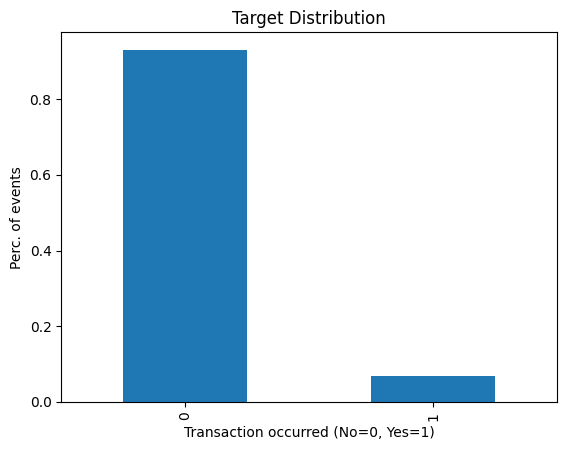

In [9]:
# Checking if the dataset is imbalanced 
data["result"].value_counts(normalize=True).plot(kind="bar")
plt.title('Target Distribution')
plt.xlabel("Transaction occurred (No=0, Yes=1)")
plt.ylabel("Perc. of events");

### Fix Dataset Issues

In [12]:
OUTLIER_PRICES_THRESH = 0.25

class PriceColsFix(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        self.exchange_b_price_median = X['exchange_b_price'].median()
        return self
    
    def transform(self, data):
        X = data.copy()
        # handle missing values
        X['exchange_a_price'].fillna(X['exchange_b_price'], inplace=True)
        X['exchange_b_price'].fillna(X['exchange_a_price'], inplace=True)
        
        # handle outliers
        mask = (X['exchange_a_price'] / X['exchange_b_price'] -1).abs() > OUTLIER_PRICES_THRESH
        X['exchange_a_price'] = np.where(mask, np.nan, X['exchange_a_price'])
        X['exchange_b_price'] = np.where(mask, np.nan, X['exchange_b_price'])
        
        # replace all remaining missing value with the median
        X['exchange_a_price'].fillna(self.exchange_b_price_median, inplace=True)
        X['exchange_b_price'].fillna(self.exchange_b_price_median, inplace=True)
        return X 

In [13]:
class UserAddressColFix(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    
    def transform(self, data):
        X = data.copy()
        # remove capitalization
        X["user_address"] = X["user_address"].str.lower()
        return X 

### Feature Engineering

In [14]:
class Profit(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X["profit"] = (X['exchange_a_price'] / X['exchange_b_price'] -1).abs()
        return X 

In [15]:
class BalanceUSDPerc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        balance_coin_usd = X["user_balance_coin_a"] * X['exchange_b_price']
        X["balance_usd_perc"] = (X['user_balance_usd']) / (X['user_balance_usd'] + balance_coin_usd)
        return X 

In [16]:
class ExchangeHighestPrice(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X["exchange_highest_price"] = (data["exchange_a_price"] > data["exchange_b_price"]).map({True:1, False:0})
        return X 

### Creating the Model 

Preparing the dataset for the split

In [17]:
X = data.drop(columns=['result'])
y = data['result']

Splitting the dataset between test and train

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25)

Creating the pipeline

In [19]:
num_cols = [
    'profit', # new column
    'balance_usd_perc', # new column
    'exchange_highest_price', # new column
    'exchange_a_price',
    'exchange_b_price',
    'exchange_b_volatility',
    'user_balance_usd',
    'user_balance_coin_a',
    'user_historical_transactions_10s',
    'user_historical_transactions_30s',
]
cat_onehot_cols = [
    "exchange_a_volatility",
    "user_address"
]
cat_target_cols = [
    "anonymous"
]

num_transformer = Pipeline(steps=[
    ('fillna', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
cat_onehot_transformer = Pipeline(steps=[
    ("cat_encoder1", OneHotEncoder())
])

cat_target_transformer = Pipeline(steps=[
    ("cat_encoder2", TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('num', num_transformer, num_cols),
    ('cat1', cat_onehot_transformer, cat_onehot_cols),
    ('cat2', cat_target_transformer, cat_target_cols),
])

In [21]:
pipeline = Pipeline([
    ("fix_price_columns", PriceColsFix()),
    ("fix_address_column", UserAddressColFix()),
    ("feat_engineering_1", Profit()),
    ("feat_engineering_2", BalanceUSDPerc()),
    ("feat_engineering_3", ExchangeHighestPrice()),
    ("preprocessor", preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

Train the model and generate the predictions

In [22]:
pipeline.fit(X_train, y_train)

/home/wramos/Desktop/2022_hack1/env2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/wramos/Desktop/2022_hack1/env2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('fix_price_columns', PriceColsFix()),
                ('fix_address_column', UserAddressColFix()),
                ('feat_engineering_1', Profit()),
                ('feat_engineering_2', BalanceUSDPerc()),
                ('feat_engineering_3', ExchangeHighestPrice()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('fillna',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScale...
                                                   'exchange_b_volatility',
                                                   'user_balance_usd',
                                                   'user_balance_coin_a',
                                                   'user_histor

In [23]:
y_scores = pipeline.predict_proba(X_test)[:,1]

Score: 0.873


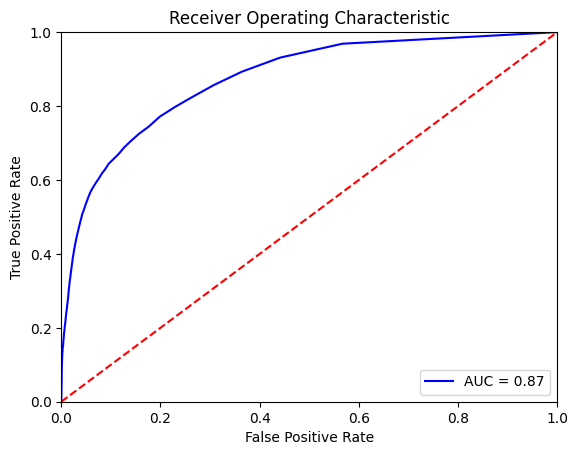

In [24]:
fpr, tpr, threshold = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("Score: "+ str(round(roc_auc,3)))
plt.show()

#### Check final score using the test set

Load the test set

In [25]:
test = pd.read_csv('data/test.csv').set_index("id")

Use the pipeline to get predictions (very simple!)

In [26]:
y_scores_final = pipeline.predict_proba(test)[:,1]

Prepare the submissions file

In [27]:
submission = pd.Series(y_scores_final,index=test.index, name='id')
submission.to_csv("submission.csv")

This should get you a 0.874!

# ignore this

In [28]:
from portal.score import load, validate, score

In [29]:
y_pred = load("submission.csv")
y_true = load("portal/data")

In [30]:
validate(y_true, y_pred)

True

In [31]:
score(y_true, y_pred)

0.8736825427308298

In [32]:
pd.read_csv("data/sample_submission.csv").shape

(112830, 2)

In [33]:
pd.read_csv("data/test.csv").shape

(112830, 11)